In [311]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# LOAD MNIST dataset from tensorflow package

In [312]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [313]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 48 * dec_in_channels / 2

def leaky_relu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [314]:
# VAE Class with CNN implementation for encoder and decoder
# inspired by https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776

def encoder(X_in, keep_prob):
    activation = leaky_relu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=3, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=3, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=3, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=leaky_relu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=leaky_relu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

In [315]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

unreshaped = tf.reshape(dec, [-1, 28*28])
# image reconstruction loss
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
# KL divergence loss
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Save model
saver = tf.train.Saver()
saver.save(sess, './vae_mnist_model', write_meta_graph=False)
# Create a write to record data for tensorboard visualization
writer = tf.summary.FileWriter('./vae_mnist_tensorboard', sess.graph)

iteration: 0, overall_loss: 178.07247924804688, recon_loss: 178.0697021484375, kl_loss: 0.0027927113696932793


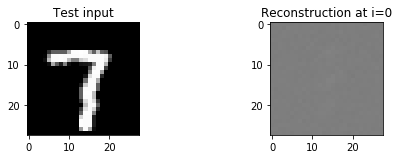

iteration: 100, overall_loss: 55.180938720703125, recon_loss: 54.436920166015625, kl_loss: 0.7440198659896851
iteration: 200, overall_loss: 49.78106689453125, recon_loss: 46.591644287109375, kl_loss: 3.1894216537475586
iteration: 300, overall_loss: 42.62956237792969, recon_loss: 37.233062744140625, kl_loss: 5.396496295928955
iteration: 400, overall_loss: 36.72160339355469, recon_loss: 29.588024139404297, kl_loss: 7.133575439453125
iteration: 500, overall_loss: 36.41753387451172, recon_loss: 29.291526794433594, kl_loss: 7.126008987426758


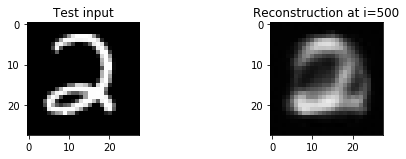

iteration: 600, overall_loss: 37.113739013671875, recon_loss: 28.929973602294922, kl_loss: 8.183769226074219
iteration: 700, overall_loss: 38.80192184448242, recon_loss: 30.579139709472656, kl_loss: 8.222785949707031
iteration: 800, overall_loss: 34.192718505859375, recon_loss: 26.116121292114258, kl_loss: 8.076595306396484
iteration: 900, overall_loss: 34.62993621826172, recon_loss: 25.587005615234375, kl_loss: 9.042930603027344
iteration: 1000, overall_loss: 33.48528289794922, recon_loss: 25.39145278930664, kl_loss: 8.093832015991211


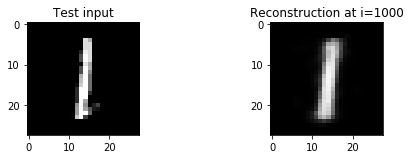

iteration: 1100, overall_loss: 34.217987060546875, recon_loss: 25.902395248413086, kl_loss: 8.315593719482422
iteration: 1200, overall_loss: 32.57960510253906, recon_loss: 23.78847885131836, kl_loss: 8.791122436523438
iteration: 1300, overall_loss: 33.45939636230469, recon_loss: 24.202411651611328, kl_loss: 9.25698471069336
iteration: 1400, overall_loss: 31.66757583618164, recon_loss: 22.835796356201172, kl_loss: 8.831781387329102
iteration: 1500, overall_loss: 31.81710433959961, recon_loss: 23.216938018798828, kl_loss: 8.600164413452148


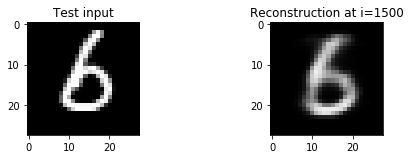

iteration: 1600, overall_loss: 29.188961029052734, recon_loss: 20.56972885131836, kl_loss: 8.619232177734375
iteration: 1700, overall_loss: 30.902164459228516, recon_loss: 21.04435157775879, kl_loss: 9.857812881469727
iteration: 1800, overall_loss: 31.92673110961914, recon_loss: 22.5343017578125, kl_loss: 9.392427444458008
iteration: 1900, overall_loss: 30.55703353881836, recon_loss: 21.30901336669922, kl_loss: 9.24802017211914
iteration: 2000, overall_loss: 31.157188415527344, recon_loss: 21.522815704345703, kl_loss: 9.634373664855957


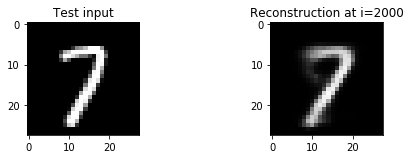

iteration: 2100, overall_loss: 31.12847328186035, recon_loss: 21.82691192626953, kl_loss: 9.301560401916504
iteration: 2200, overall_loss: 32.51939392089844, recon_loss: 23.15595245361328, kl_loss: 9.363441467285156
iteration: 2300, overall_loss: 31.5080623626709, recon_loss: 21.90536117553711, kl_loss: 9.60269832611084
iteration: 2400, overall_loss: 30.776123046875, recon_loss: 21.631521224975586, kl_loss: 9.144601821899414
iteration: 2500, overall_loss: 31.122425079345703, recon_loss: 21.733489990234375, kl_loss: 9.388935089111328


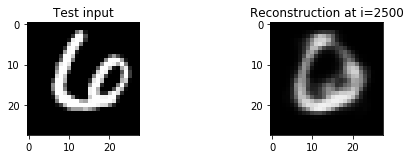

iteration: 2600, overall_loss: 31.55813980102539, recon_loss: 21.853389739990234, kl_loss: 9.704750061035156
iteration: 2700, overall_loss: 30.782894134521484, recon_loss: 21.16484260559082, kl_loss: 9.618049621582031
iteration: 2800, overall_loss: 28.148759841918945, recon_loss: 18.60220718383789, kl_loss: 9.546550750732422
iteration: 2900, overall_loss: 31.723388671875, recon_loss: 21.98822021484375, kl_loss: 9.735166549682617
iteration: 3000, overall_loss: 30.114688873291016, recon_loss: 20.623397827148438, kl_loss: 9.491290092468262


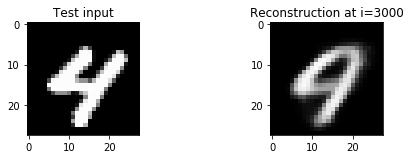

iteration: 3100, overall_loss: 31.03223419189453, recon_loss: 21.508928298950195, kl_loss: 9.523307800292969
iteration: 3200, overall_loss: 30.84157371520996, recon_loss: 21.79197120666504, kl_loss: 9.049602508544922
iteration: 3300, overall_loss: 31.4747371673584, recon_loss: 21.859161376953125, kl_loss: 9.61557388305664
iteration: 3400, overall_loss: 28.889354705810547, recon_loss: 18.434858322143555, kl_loss: 10.454497337341309
iteration: 3500, overall_loss: 29.71764373779297, recon_loss: 19.79804039001465, kl_loss: 9.91960334777832


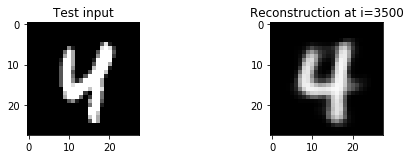

iteration: 3600, overall_loss: 31.512603759765625, recon_loss: 21.862197875976562, kl_loss: 9.650405883789062
iteration: 3700, overall_loss: 29.364173889160156, recon_loss: 20.05923843383789, kl_loss: 9.304933547973633
iteration: 3800, overall_loss: 29.817150115966797, recon_loss: 20.611698150634766, kl_loss: 9.205452919006348
iteration: 3900, overall_loss: 30.13548469543457, recon_loss: 20.478675842285156, kl_loss: 9.656811714172363
iteration: 4000, overall_loss: 29.13245391845703, recon_loss: 19.389293670654297, kl_loss: 9.743162155151367


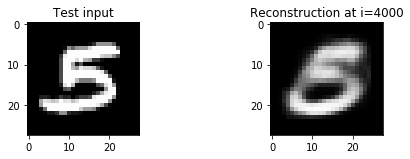

iteration: 4100, overall_loss: 27.13264274597168, recon_loss: 17.360790252685547, kl_loss: 9.771854400634766
iteration: 4200, overall_loss: 29.297470092773438, recon_loss: 19.631637573242188, kl_loss: 9.665831565856934
iteration: 4300, overall_loss: 29.043012619018555, recon_loss: 19.445499420166016, kl_loss: 9.597513198852539
iteration: 4400, overall_loss: 29.220760345458984, recon_loss: 19.243343353271484, kl_loss: 9.977415084838867
iteration: 4500, overall_loss: 30.203615188598633, recon_loss: 21.015857696533203, kl_loss: 9.187756538391113


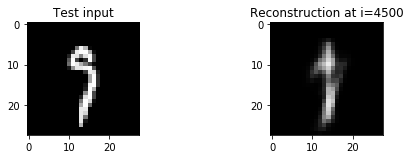

iteration: 4600, overall_loss: 31.42932891845703, recon_loss: 21.541805267333984, kl_loss: 9.887521743774414
iteration: 4700, overall_loss: 29.96613311767578, recon_loss: 20.071680068969727, kl_loss: 9.894455909729004
iteration: 4800, overall_loss: 27.843250274658203, recon_loss: 18.532407760620117, kl_loss: 9.310842514038086
iteration: 4900, overall_loss: 30.181293487548828, recon_loss: 20.653308868408203, kl_loss: 9.527983665466309
iteration: 5000, overall_loss: 30.327693939208984, recon_loss: 20.129878997802734, kl_loss: 10.197813034057617


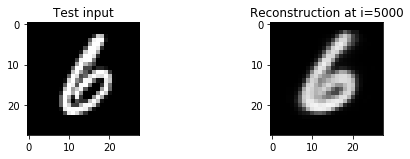

iteration: 5100, overall_loss: 29.476863861083984, recon_loss: 19.660259246826172, kl_loss: 9.816608428955078
iteration: 5200, overall_loss: 30.980838775634766, recon_loss: 20.490211486816406, kl_loss: 10.490629196166992
iteration: 5300, overall_loss: 31.41067123413086, recon_loss: 21.314685821533203, kl_loss: 10.095987319946289
iteration: 5400, overall_loss: 28.91598892211914, recon_loss: 19.095901489257812, kl_loss: 9.820083618164062
iteration: 5500, overall_loss: 29.990304946899414, recon_loss: 20.017597198486328, kl_loss: 9.972707748413086


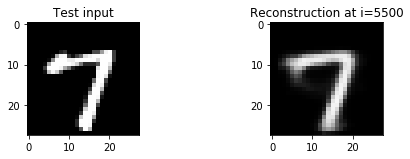

iteration: 5600, overall_loss: 30.571556091308594, recon_loss: 21.164531707763672, kl_loss: 9.407024383544922
iteration: 5700, overall_loss: 28.6622371673584, recon_loss: 18.949657440185547, kl_loss: 9.712579727172852
iteration: 5800, overall_loss: 28.59835433959961, recon_loss: 18.7078857421875, kl_loss: 9.890466690063477
iteration: 5900, overall_loss: 29.379695892333984, recon_loss: 19.388717651367188, kl_loss: 9.99098014831543
iteration: 6000, overall_loss: 29.481815338134766, recon_loss: 19.761123657226562, kl_loss: 9.72069263458252


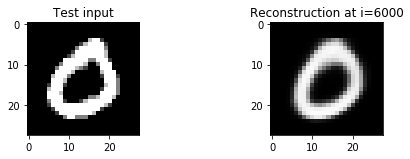

iteration: 6100, overall_loss: 29.113449096679688, recon_loss: 19.012718200683594, kl_loss: 10.100732803344727
iteration: 6200, overall_loss: 32.08034133911133, recon_loss: 21.749107360839844, kl_loss: 10.331233024597168
iteration: 6300, overall_loss: 30.194252014160156, recon_loss: 20.870046615600586, kl_loss: 9.32420539855957
iteration: 6400, overall_loss: 29.531150817871094, recon_loss: 19.627761840820312, kl_loss: 9.903388977050781
iteration: 6500, overall_loss: 28.776702880859375, recon_loss: 19.247203826904297, kl_loss: 9.529499053955078


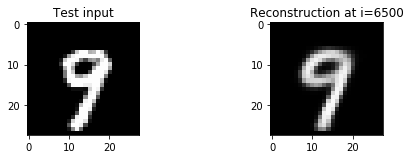

iteration: 6600, overall_loss: 30.296777725219727, recon_loss: 20.032394409179688, kl_loss: 10.264384269714355
iteration: 6700, overall_loss: 30.34313201904297, recon_loss: 20.11478042602539, kl_loss: 10.228351593017578
iteration: 6800, overall_loss: 28.75731658935547, recon_loss: 18.275474548339844, kl_loss: 10.481842041015625
iteration: 6900, overall_loss: 28.74382972717285, recon_loss: 18.670751571655273, kl_loss: 10.073079109191895
iteration: 7000, overall_loss: 28.675350189208984, recon_loss: 18.465484619140625, kl_loss: 10.209867477416992


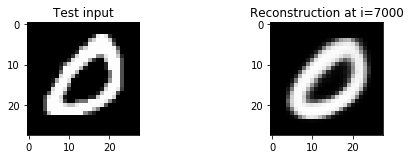

iteration: 7100, overall_loss: 28.47378921508789, recon_loss: 18.576406478881836, kl_loss: 9.897383689880371
iteration: 7200, overall_loss: 29.291141510009766, recon_loss: 18.636577606201172, kl_loss: 10.654565811157227
iteration: 7300, overall_loss: 27.47359275817871, recon_loss: 17.801034927368164, kl_loss: 9.67255973815918
iteration: 7400, overall_loss: 30.90804672241211, recon_loss: 21.427295684814453, kl_loss: 9.480752944946289
iteration: 7500, overall_loss: 28.545480728149414, recon_loss: 17.804439544677734, kl_loss: 10.74103832244873


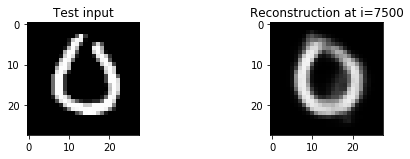

iteration: 7600, overall_loss: 29.257299423217773, recon_loss: 19.040874481201172, kl_loss: 10.21642780303955
iteration: 7700, overall_loss: 28.45633888244629, recon_loss: 18.677223205566406, kl_loss: 9.77911376953125
iteration: 7800, overall_loss: 28.355945587158203, recon_loss: 18.054012298583984, kl_loss: 10.301932334899902
iteration: 7900, overall_loss: 28.90822982788086, recon_loss: 19.223670959472656, kl_loss: 9.684555053710938
iteration: 8000, overall_loss: 27.561901092529297, recon_loss: 16.504018783569336, kl_loss: 11.057880401611328


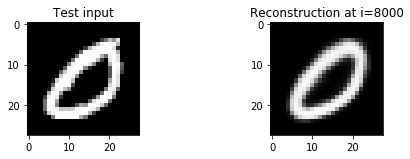

iteration: 8100, overall_loss: 27.41699981689453, recon_loss: 17.546466827392578, kl_loss: 9.87053394317627
iteration: 8200, overall_loss: 28.77098274230957, recon_loss: 18.899808883666992, kl_loss: 9.871172904968262
iteration: 8300, overall_loss: 30.557659149169922, recon_loss: 20.269710540771484, kl_loss: 10.287949562072754
iteration: 8400, overall_loss: 29.607694625854492, recon_loss: 19.201610565185547, kl_loss: 10.406082153320312
iteration: 8500, overall_loss: 29.928699493408203, recon_loss: 19.635364532470703, kl_loss: 10.2933349609375


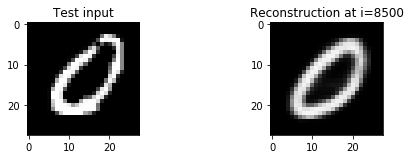

iteration: 8600, overall_loss: 27.418209075927734, recon_loss: 16.608428955078125, kl_loss: 10.809776306152344
iteration: 8700, overall_loss: 27.78899383544922, recon_loss: 17.307254791259766, kl_loss: 10.481739044189453
iteration: 8800, overall_loss: 26.724639892578125, recon_loss: 16.7039737701416, kl_loss: 10.020666122436523
iteration: 8900, overall_loss: 28.337203979492188, recon_loss: 18.22406768798828, kl_loss: 10.113136291503906
iteration: 9000, overall_loss: 30.42876434326172, recon_loss: 20.595197677612305, kl_loss: 9.833566665649414


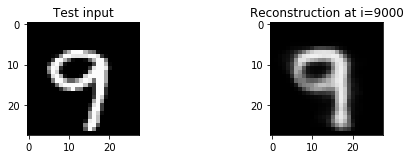

iteration: 9100, overall_loss: 29.9282283782959, recon_loss: 19.776208877563477, kl_loss: 10.152018547058105
iteration: 9200, overall_loss: 27.806062698364258, recon_loss: 18.318470001220703, kl_loss: 9.487594604492188
iteration: 9300, overall_loss: 27.878023147583008, recon_loss: 17.077381134033203, kl_loss: 10.800642013549805
iteration: 9400, overall_loss: 28.186708450317383, recon_loss: 17.793245315551758, kl_loss: 10.393463134765625
iteration: 9500, overall_loss: 27.381267547607422, recon_loss: 17.437702178955078, kl_loss: 9.943563461303711


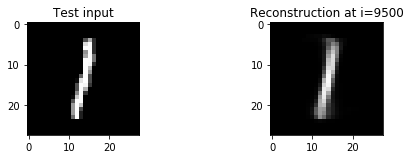

iteration: 9600, overall_loss: 29.869674682617188, recon_loss: 19.55738639831543, kl_loss: 10.312285423278809
iteration: 9700, overall_loss: 27.78927230834961, recon_loss: 17.438705444335938, kl_loss: 10.350566864013672
iteration: 9800, overall_loss: 28.931364059448242, recon_loss: 18.70561981201172, kl_loss: 10.22574520111084
iteration: 9900, overall_loss: 29.141008377075195, recon_loss: 18.79486083984375, kl_loss: 10.346146583557129
iteration: 10000, overall_loss: 26.63075065612793, recon_loss: 15.849254608154297, kl_loss: 10.781496047973633


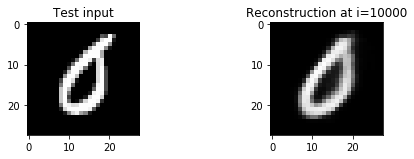

iteration: 10100, overall_loss: 29.319387435913086, recon_loss: 18.297849655151367, kl_loss: 11.021535873413086
iteration: 10200, overall_loss: 30.253673553466797, recon_loss: 19.715057373046875, kl_loss: 10.538614273071289
iteration: 10300, overall_loss: 27.37476348876953, recon_loss: 17.580036163330078, kl_loss: 9.79472541809082
iteration: 10400, overall_loss: 28.76036834716797, recon_loss: 18.093875885009766, kl_loss: 10.666492462158203
iteration: 10500, overall_loss: 26.174488067626953, recon_loss: 16.22467041015625, kl_loss: 9.949816703796387


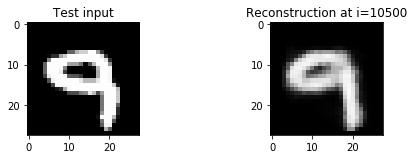

iteration: 10600, overall_loss: 29.866992950439453, recon_loss: 19.06139373779297, kl_loss: 10.805599212646484
iteration: 10700, overall_loss: 28.501163482666016, recon_loss: 18.00180435180664, kl_loss: 10.499360084533691
iteration: 10800, overall_loss: 28.693918228149414, recon_loss: 18.48863983154297, kl_loss: 10.205276489257812
iteration: 10900, overall_loss: 27.367429733276367, recon_loss: 17.395320892333984, kl_loss: 9.972107887268066
iteration: 11000, overall_loss: 27.093231201171875, recon_loss: 16.85565757751465, kl_loss: 10.237574577331543


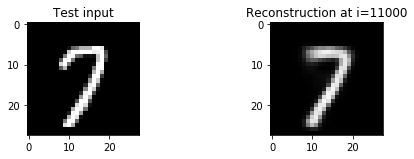

iteration: 11100, overall_loss: 29.195234298706055, recon_loss: 18.933706283569336, kl_loss: 10.261528015136719
iteration: 11200, overall_loss: 28.440637588500977, recon_loss: 18.53852081298828, kl_loss: 9.902115821838379
iteration: 11300, overall_loss: 26.078948974609375, recon_loss: 16.21312713623047, kl_loss: 9.865819931030273
iteration: 11400, overall_loss: 26.411611557006836, recon_loss: 15.92944049835205, kl_loss: 10.482172012329102
iteration: 11500, overall_loss: 28.240673065185547, recon_loss: 18.208133697509766, kl_loss: 10.032539367675781


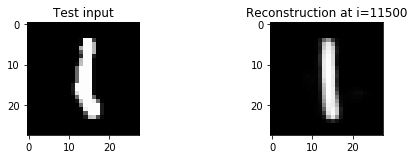

iteration: 11600, overall_loss: 26.730640411376953, recon_loss: 16.72068214416504, kl_loss: 10.009958267211914
iteration: 11700, overall_loss: 27.590988159179688, recon_loss: 16.78067970275879, kl_loss: 10.810307502746582
iteration: 11800, overall_loss: 29.59540557861328, recon_loss: 18.92740249633789, kl_loss: 10.66800308227539
iteration: 11900, overall_loss: 28.162267684936523, recon_loss: 18.16150665283203, kl_loss: 10.00075912475586
iteration: 12000, overall_loss: 28.19876480102539, recon_loss: 18.076894760131836, kl_loss: 10.121870994567871


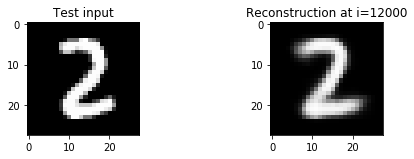

iteration: 12100, overall_loss: 28.06448745727539, recon_loss: 17.574378967285156, kl_loss: 10.490106582641602
iteration: 12200, overall_loss: 25.672576904296875, recon_loss: 16.044187545776367, kl_loss: 9.628388404846191
iteration: 12300, overall_loss: 28.360002517700195, recon_loss: 17.718730926513672, kl_loss: 10.641273498535156
iteration: 12400, overall_loss: 26.31412124633789, recon_loss: 16.45149803161621, kl_loss: 9.862625122070312
iteration: 12500, overall_loss: 29.771459579467773, recon_loss: 19.343360900878906, kl_loss: 10.42809772491455


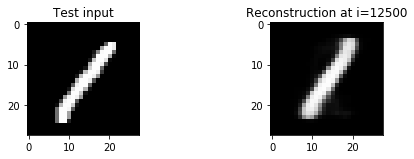

iteration: 12600, overall_loss: 29.280258178710938, recon_loss: 19.120403289794922, kl_loss: 10.159855842590332
iteration: 12700, overall_loss: 28.13927459716797, recon_loss: 18.137393951416016, kl_loss: 10.00188159942627
iteration: 12800, overall_loss: 28.06844139099121, recon_loss: 17.519287109375, kl_loss: 10.549154281616211
iteration: 12900, overall_loss: 28.367401123046875, recon_loss: 17.044750213623047, kl_loss: 11.322649955749512
iteration: 13000, overall_loss: 25.892423629760742, recon_loss: 15.90982723236084, kl_loss: 9.982595443725586


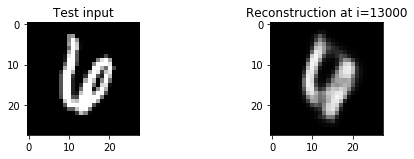

iteration: 13100, overall_loss: 29.519819259643555, recon_loss: 18.649456024169922, kl_loss: 10.870363235473633
iteration: 13200, overall_loss: 26.28338050842285, recon_loss: 16.196470260620117, kl_loss: 10.086910247802734
iteration: 13300, overall_loss: 28.307897567749023, recon_loss: 17.299074172973633, kl_loss: 11.008825302124023
iteration: 13400, overall_loss: 30.593799591064453, recon_loss: 19.784194946289062, kl_loss: 10.809602737426758
iteration: 13500, overall_loss: 27.85969352722168, recon_loss: 18.097610473632812, kl_loss: 9.762083053588867


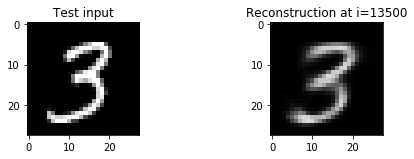

iteration: 13600, overall_loss: 28.95442008972168, recon_loss: 18.2547550201416, kl_loss: 10.699666023254395
iteration: 13700, overall_loss: 27.50436019897461, recon_loss: 17.01310157775879, kl_loss: 10.491259574890137
iteration: 13800, overall_loss: 27.849483489990234, recon_loss: 17.480613708496094, kl_loss: 10.368865966796875
iteration: 13900, overall_loss: 26.87701416015625, recon_loss: 16.61198616027832, kl_loss: 10.265028953552246
iteration: 14000, overall_loss: 26.662363052368164, recon_loss: 17.1419620513916, kl_loss: 9.520401000976562


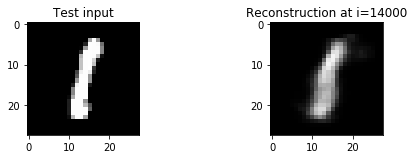

iteration: 14100, overall_loss: 28.46207618713379, recon_loss: 18.123506546020508, kl_loss: 10.338569641113281
iteration: 14200, overall_loss: 28.290132522583008, recon_loss: 18.01901626586914, kl_loss: 10.271114349365234
iteration: 14300, overall_loss: 28.72049331665039, recon_loss: 17.781185150146484, kl_loss: 10.939308166503906
iteration: 14400, overall_loss: 28.29634666442871, recon_loss: 18.060924530029297, kl_loss: 10.235422134399414
iteration: 14500, overall_loss: 29.278005599975586, recon_loss: 18.831222534179688, kl_loss: 10.446782112121582


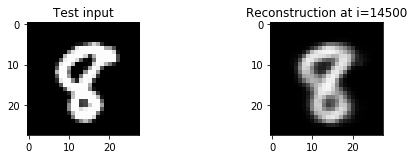

iteration: 14600, overall_loss: 30.699247360229492, recon_loss: 20.027332305908203, kl_loss: 10.671916961669922
iteration: 14700, overall_loss: 29.204469680786133, recon_loss: 18.773197174072266, kl_loss: 10.431272506713867
iteration: 14800, overall_loss: 27.881624221801758, recon_loss: 17.334012985229492, kl_loss: 10.547612190246582
iteration: 14900, overall_loss: 26.8609619140625, recon_loss: 15.794675827026367, kl_loss: 11.066286087036133
iteration: 15000, overall_loss: 27.7636661529541, recon_loss: 16.684219360351562, kl_loss: 11.079445838928223


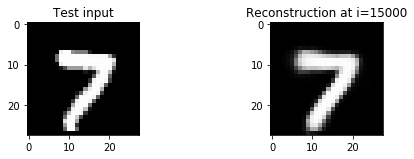

iteration: 15100, overall_loss: 27.24069595336914, recon_loss: 16.92746353149414, kl_loss: 10.313232421875
iteration: 15200, overall_loss: 28.483959197998047, recon_loss: 18.0089168548584, kl_loss: 10.475044250488281
iteration: 15300, overall_loss: 27.52505111694336, recon_loss: 17.03190040588379, kl_loss: 10.493148803710938
iteration: 15400, overall_loss: 26.852516174316406, recon_loss: 16.486051559448242, kl_loss: 10.366466522216797
iteration: 15500, overall_loss: 28.931121826171875, recon_loss: 18.854957580566406, kl_loss: 10.076165199279785


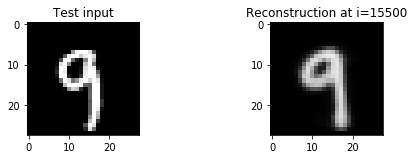

iteration: 15600, overall_loss: 25.52124786376953, recon_loss: 15.125677108764648, kl_loss: 10.395573616027832
iteration: 15700, overall_loss: 27.256805419921875, recon_loss: 16.724594116210938, kl_loss: 10.53221321105957
iteration: 15800, overall_loss: 28.86161994934082, recon_loss: 18.182573318481445, kl_loss: 10.679047584533691
iteration: 15900, overall_loss: 30.195995330810547, recon_loss: 19.72592544555664, kl_loss: 10.470069885253906
iteration: 16000, overall_loss: 29.125713348388672, recon_loss: 18.649789810180664, kl_loss: 10.475921630859375


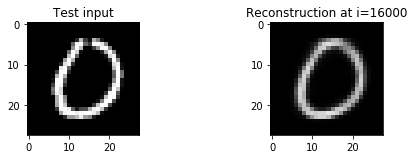

iteration: 16100, overall_loss: 28.98072624206543, recon_loss: 17.972293853759766, kl_loss: 11.008432388305664
iteration: 16200, overall_loss: 27.797359466552734, recon_loss: 17.365907669067383, kl_loss: 10.431453704833984
iteration: 16300, overall_loss: 27.517789840698242, recon_loss: 16.894472122192383, kl_loss: 10.62331771850586
iteration: 16400, overall_loss: 29.89447784423828, recon_loss: 19.095691680908203, kl_loss: 10.798787117004395
iteration: 16500, overall_loss: 28.175045013427734, recon_loss: 17.126081466674805, kl_loss: 11.04896354675293


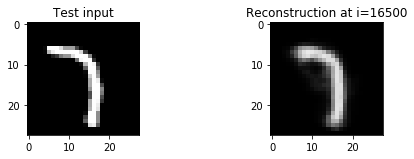

iteration: 16600, overall_loss: 28.64803695678711, recon_loss: 17.689149856567383, kl_loss: 10.958888053894043
iteration: 16700, overall_loss: 26.790420532226562, recon_loss: 16.33051872253418, kl_loss: 10.45989990234375
iteration: 16800, overall_loss: 27.653308868408203, recon_loss: 17.466323852539062, kl_loss: 10.18698501586914
iteration: 16900, overall_loss: 26.69129180908203, recon_loss: 16.2200870513916, kl_loss: 10.471203804016113
iteration: 17000, overall_loss: 28.18732452392578, recon_loss: 17.423734664916992, kl_loss: 10.763591766357422


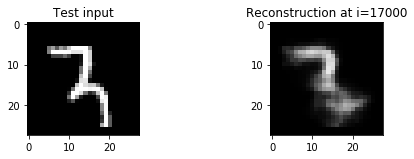

iteration: 17100, overall_loss: 29.115398406982422, recon_loss: 17.90448760986328, kl_loss: 11.210909843444824
iteration: 17200, overall_loss: 25.914323806762695, recon_loss: 15.864155769348145, kl_loss: 10.050168991088867
iteration: 17300, overall_loss: 30.32907485961914, recon_loss: 19.42194366455078, kl_loss: 10.90713119506836
iteration: 17400, overall_loss: 27.303958892822266, recon_loss: 16.335617065429688, kl_loss: 10.968343734741211
iteration: 17500, overall_loss: 29.140487670898438, recon_loss: 18.075037002563477, kl_loss: 11.065450668334961


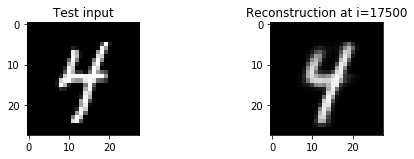

iteration: 17600, overall_loss: 27.678335189819336, recon_loss: 16.990123748779297, kl_loss: 10.688212394714355
iteration: 17700, overall_loss: 27.81650161743164, recon_loss: 17.220996856689453, kl_loss: 10.595504760742188
iteration: 17800, overall_loss: 26.59111976623535, recon_loss: 15.749266624450684, kl_loss: 10.841852188110352
iteration: 17900, overall_loss: 28.517959594726562, recon_loss: 17.89990997314453, kl_loss: 10.618049621582031
iteration: 18000, overall_loss: 27.13236427307129, recon_loss: 16.935049057006836, kl_loss: 10.197315216064453


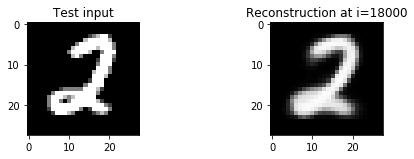

iteration: 18100, overall_loss: 27.748432159423828, recon_loss: 17.60346794128418, kl_loss: 10.144964218139648
iteration: 18200, overall_loss: 26.128063201904297, recon_loss: 15.700499534606934, kl_loss: 10.427565574645996
iteration: 18300, overall_loss: 27.37672996520996, recon_loss: 17.366390228271484, kl_loss: 10.01033878326416
iteration: 18400, overall_loss: 28.032093048095703, recon_loss: 17.615501403808594, kl_loss: 10.416590690612793
iteration: 18500, overall_loss: 27.763004302978516, recon_loss: 17.388561248779297, kl_loss: 10.37444019317627


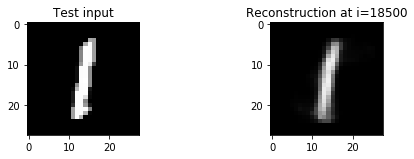

iteration: 18600, overall_loss: 27.901348114013672, recon_loss: 17.08650016784668, kl_loss: 10.814847946166992
iteration: 18700, overall_loss: 28.498064041137695, recon_loss: 17.637977600097656, kl_loss: 10.860086441040039
iteration: 18800, overall_loss: 28.14555549621582, recon_loss: 17.240083694458008, kl_loss: 10.905470848083496
iteration: 18900, overall_loss: 27.827543258666992, recon_loss: 17.07090187072754, kl_loss: 10.75664234161377
iteration: 19000, overall_loss: 28.641216278076172, recon_loss: 17.775047302246094, kl_loss: 10.866169929504395


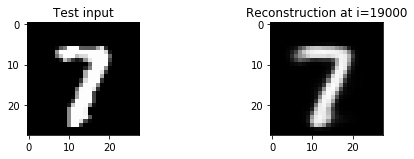

iteration: 19100, overall_loss: 25.753124237060547, recon_loss: 15.031858444213867, kl_loss: 10.721267700195312
iteration: 19200, overall_loss: 26.408676147460938, recon_loss: 15.851435661315918, kl_loss: 10.557241439819336
iteration: 19300, overall_loss: 24.321407318115234, recon_loss: 13.644593238830566, kl_loss: 10.676813125610352
iteration: 19400, overall_loss: 28.840106964111328, recon_loss: 18.419158935546875, kl_loss: 10.420950889587402
iteration: 19500, overall_loss: 29.641788482666016, recon_loss: 19.20236587524414, kl_loss: 10.439420700073242


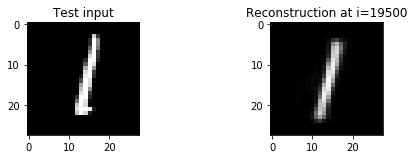

iteration: 19600, overall_loss: 27.751834869384766, recon_loss: 16.525081634521484, kl_loss: 11.226753234863281
iteration: 19700, overall_loss: 26.395261764526367, recon_loss: 16.08720588684082, kl_loss: 10.308055877685547
iteration: 19800, overall_loss: 30.373123168945312, recon_loss: 19.49384117126465, kl_loss: 10.87928295135498
iteration: 19900, overall_loss: 28.443832397460938, recon_loss: 17.65333366394043, kl_loss: 10.790497779846191
iteration: 20000, overall_loss: 27.166841506958008, recon_loss: 15.97262191772461, kl_loss: 11.194220542907715


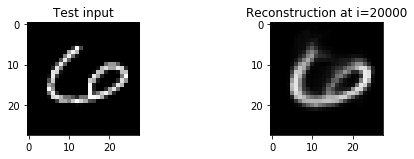

iteration: 20100, overall_loss: 27.052682876586914, recon_loss: 16.335039138793945, kl_loss: 10.717643737792969
iteration: 20200, overall_loss: 26.565784454345703, recon_loss: 15.859647750854492, kl_loss: 10.706137657165527
iteration: 20300, overall_loss: 27.292034149169922, recon_loss: 17.009395599365234, kl_loss: 10.282636642456055
iteration: 20400, overall_loss: 28.01749038696289, recon_loss: 16.292844772338867, kl_loss: 11.724645614624023
iteration: 20500, overall_loss: 25.249553680419922, recon_loss: 14.701969146728516, kl_loss: 10.547584533691406


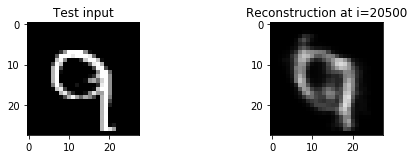

iteration: 20600, overall_loss: 26.077369689941406, recon_loss: 15.426316261291504, kl_loss: 10.651052474975586
iteration: 20700, overall_loss: 27.69607925415039, recon_loss: 16.375661849975586, kl_loss: 11.320415496826172
iteration: 20800, overall_loss: 28.306713104248047, recon_loss: 17.70435905456543, kl_loss: 10.6023530960083
iteration: 20900, overall_loss: 27.507089614868164, recon_loss: 16.46483039855957, kl_loss: 11.042258262634277
iteration: 21000, overall_loss: 28.023738861083984, recon_loss: 17.35959243774414, kl_loss: 10.664143562316895


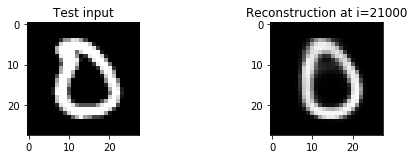

iteration: 21100, overall_loss: 27.584091186523438, recon_loss: 16.550804138183594, kl_loss: 11.033286094665527
iteration: 21200, overall_loss: 28.757434844970703, recon_loss: 17.811077117919922, kl_loss: 10.946355819702148
iteration: 21300, overall_loss: 28.844606399536133, recon_loss: 18.119918823242188, kl_loss: 10.724685668945312
iteration: 21400, overall_loss: 28.957490921020508, recon_loss: 18.133085250854492, kl_loss: 10.8244047164917
iteration: 21500, overall_loss: 27.39738655090332, recon_loss: 16.747591018676758, kl_loss: 10.649795532226562


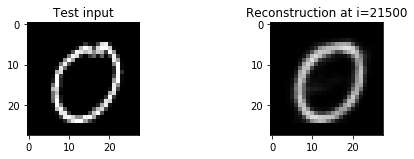

iteration: 21600, overall_loss: 27.22623062133789, recon_loss: 16.663578033447266, kl_loss: 10.562654495239258
iteration: 21700, overall_loss: 28.111154556274414, recon_loss: 17.738996505737305, kl_loss: 10.372159957885742
iteration: 21800, overall_loss: 28.378475189208984, recon_loss: 17.581737518310547, kl_loss: 10.796736717224121
iteration: 21900, overall_loss: 27.778392791748047, recon_loss: 16.642885208129883, kl_loss: 11.135507583618164
iteration: 22000, overall_loss: 28.83416748046875, recon_loss: 18.31041717529297, kl_loss: 10.523746490478516


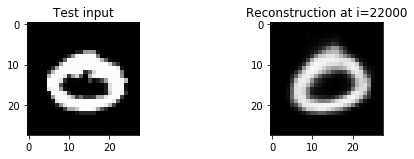

iteration: 22100, overall_loss: 27.67914581298828, recon_loss: 16.916229248046875, kl_loss: 10.762917518615723
iteration: 22200, overall_loss: 27.39499282836914, recon_loss: 16.518604278564453, kl_loss: 10.876388549804688
iteration: 22300, overall_loss: 27.297279357910156, recon_loss: 16.598169326782227, kl_loss: 10.699108123779297
iteration: 22400, overall_loss: 25.80572509765625, recon_loss: 15.476004600524902, kl_loss: 10.329719543457031
iteration: 22500, overall_loss: 28.318626403808594, recon_loss: 17.55915069580078, kl_loss: 10.75947380065918


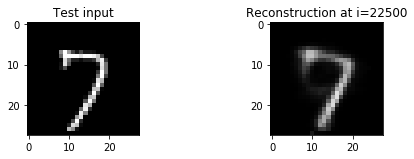

iteration: 22600, overall_loss: 28.879196166992188, recon_loss: 18.10972023010254, kl_loss: 10.769476890563965
iteration: 22700, overall_loss: 26.322223663330078, recon_loss: 15.725778579711914, kl_loss: 10.59644603729248
iteration: 22800, overall_loss: 27.269725799560547, recon_loss: 17.113109588623047, kl_loss: 10.1566162109375
iteration: 22900, overall_loss: 29.035091400146484, recon_loss: 18.476192474365234, kl_loss: 10.558900833129883
iteration: 23000, overall_loss: 26.95527458190918, recon_loss: 15.973785400390625, kl_loss: 10.981489181518555


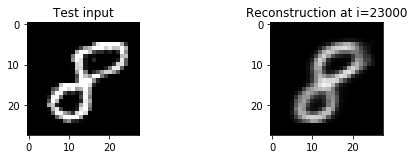

iteration: 23100, overall_loss: 26.60763168334961, recon_loss: 16.34339141845703, kl_loss: 10.264241218566895
iteration: 23200, overall_loss: 26.716384887695312, recon_loss: 15.921051979064941, kl_loss: 10.795331954956055
iteration: 23300, overall_loss: 26.462709426879883, recon_loss: 15.959610939025879, kl_loss: 10.50309944152832
iteration: 23400, overall_loss: 26.930706024169922, recon_loss: 15.897512435913086, kl_loss: 11.033193588256836
iteration: 23500, overall_loss: 27.516952514648438, recon_loss: 16.657764434814453, kl_loss: 10.859186172485352


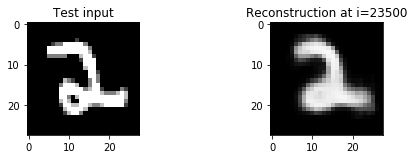

iteration: 23600, overall_loss: 25.28213119506836, recon_loss: 15.158135414123535, kl_loss: 10.123993873596191
iteration: 23700, overall_loss: 25.137205123901367, recon_loss: 14.597129821777344, kl_loss: 10.540075302124023
iteration: 23800, overall_loss: 28.246625900268555, recon_loss: 17.266937255859375, kl_loss: 10.97968864440918
iteration: 23900, overall_loss: 27.57131576538086, recon_loss: 17.151870727539062, kl_loss: 10.41944408416748
iteration: 24000, overall_loss: 26.90764045715332, recon_loss: 15.984418869018555, kl_loss: 10.923221588134766


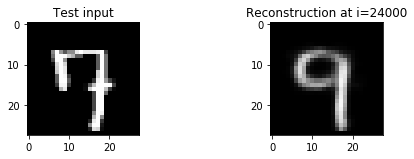

iteration: 24100, overall_loss: 28.643840789794922, recon_loss: 17.83041000366211, kl_loss: 10.81342887878418
iteration: 24200, overall_loss: 27.809734344482422, recon_loss: 16.548381805419922, kl_loss: 11.2613525390625
iteration: 24300, overall_loss: 28.464136123657227, recon_loss: 17.730487823486328, kl_loss: 10.733649253845215
iteration: 24400, overall_loss: 29.350017547607422, recon_loss: 18.963558197021484, kl_loss: 10.38646125793457
iteration: 24500, overall_loss: 25.933570861816406, recon_loss: 15.377179145812988, kl_loss: 10.556390762329102


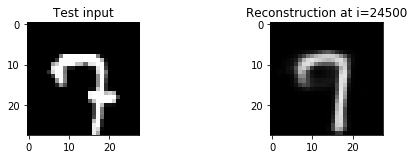

iteration: 24600, overall_loss: 30.030969619750977, recon_loss: 18.986146926879883, kl_loss: 11.04482364654541
iteration: 24700, overall_loss: 28.221446990966797, recon_loss: 17.532949447631836, kl_loss: 10.688497543334961
iteration: 24800, overall_loss: 26.53851318359375, recon_loss: 16.06761932373047, kl_loss: 10.470893859863281
iteration: 24900, overall_loss: 27.80770492553711, recon_loss: 17.442150115966797, kl_loss: 10.365554809570312
iteration: 25000, overall_loss: 26.926162719726562, recon_loss: 16.263301849365234, kl_loss: 10.662860870361328


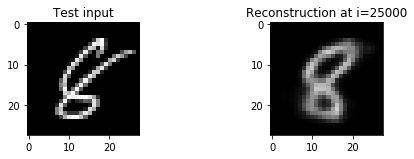

iteration: 25100, overall_loss: 27.517719268798828, recon_loss: 16.937511444091797, kl_loss: 10.580209732055664
iteration: 25200, overall_loss: 27.617801666259766, recon_loss: 16.803817749023438, kl_loss: 10.813983917236328
iteration: 25300, overall_loss: 27.04468536376953, recon_loss: 16.604656219482422, kl_loss: 10.440027236938477
iteration: 25400, overall_loss: 27.58941650390625, recon_loss: 16.436473846435547, kl_loss: 11.15294361114502
iteration: 25500, overall_loss: 26.44129180908203, recon_loss: 15.98758316040039, kl_loss: 10.45371150970459


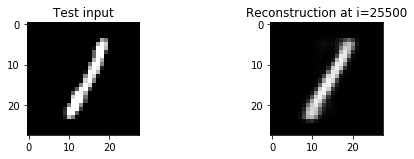

iteration: 25600, overall_loss: 27.27129364013672, recon_loss: 16.82061767578125, kl_loss: 10.450676918029785
iteration: 25700, overall_loss: 26.45688819885254, recon_loss: 16.655094146728516, kl_loss: 9.801794052124023
iteration: 25800, overall_loss: 28.126285552978516, recon_loss: 16.89565658569336, kl_loss: 11.230628967285156
iteration: 25900, overall_loss: 25.256526947021484, recon_loss: 14.6563138961792, kl_loss: 10.600213050842285
iteration: 26000, overall_loss: 26.706825256347656, recon_loss: 15.968536376953125, kl_loss: 10.738287925720215


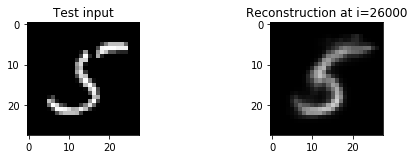

iteration: 26100, overall_loss: 25.86673927307129, recon_loss: 14.610034942626953, kl_loss: 11.256704330444336
iteration: 26200, overall_loss: 27.971256256103516, recon_loss: 17.111812591552734, kl_loss: 10.859445571899414
iteration: 26300, overall_loss: 28.31260871887207, recon_loss: 17.046104431152344, kl_loss: 11.266504287719727
iteration: 26400, overall_loss: 29.623796463012695, recon_loss: 18.685989379882812, kl_loss: 10.937807083129883
iteration: 26500, overall_loss: 27.6043643951416, recon_loss: 16.62676239013672, kl_loss: 10.977601051330566


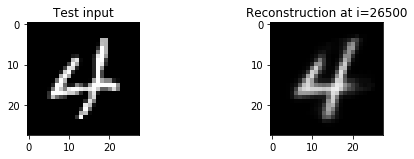

iteration: 26600, overall_loss: 25.757505416870117, recon_loss: 15.381552696228027, kl_loss: 10.375951766967773
iteration: 26700, overall_loss: 26.118202209472656, recon_loss: 15.334197998046875, kl_loss: 10.784003257751465
iteration: 26800, overall_loss: 26.32845687866211, recon_loss: 15.950273513793945, kl_loss: 10.37818431854248
iteration: 26900, overall_loss: 27.20416259765625, recon_loss: 16.45193862915039, kl_loss: 10.75222396850586
iteration: 27000, overall_loss: 26.616519927978516, recon_loss: 15.809091567993164, kl_loss: 10.807428359985352


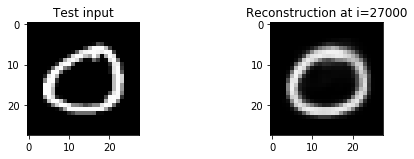

iteration: 27100, overall_loss: 28.125972747802734, recon_loss: 17.561203002929688, kl_loss: 10.56477165222168
iteration: 27200, overall_loss: 27.73581886291504, recon_loss: 17.07750129699707, kl_loss: 10.658317565917969
iteration: 27300, overall_loss: 28.15566635131836, recon_loss: 17.349287033081055, kl_loss: 10.806379318237305
iteration: 27400, overall_loss: 26.735078811645508, recon_loss: 15.731008529663086, kl_loss: 11.004070281982422
iteration: 27500, overall_loss: 30.884048461914062, recon_loss: 20.31576156616211, kl_loss: 10.568288803100586


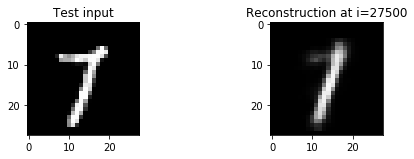

iteration: 27600, overall_loss: 26.328998565673828, recon_loss: 15.853039741516113, kl_loss: 10.475961685180664
iteration: 27700, overall_loss: 27.37494659423828, recon_loss: 16.16870880126953, kl_loss: 11.206238746643066
iteration: 27800, overall_loss: 27.909650802612305, recon_loss: 17.389156341552734, kl_loss: 10.52049446105957
iteration: 27900, overall_loss: 25.884809494018555, recon_loss: 15.744856834411621, kl_loss: 10.139951705932617
iteration: 28000, overall_loss: 25.753589630126953, recon_loss: 15.015533447265625, kl_loss: 10.738055229187012


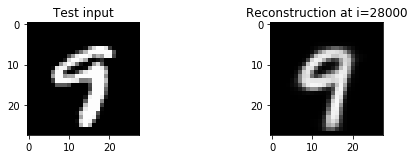

iteration: 28100, overall_loss: 26.70099639892578, recon_loss: 15.932239532470703, kl_loss: 10.768754959106445
iteration: 28200, overall_loss: 27.206031799316406, recon_loss: 16.276649475097656, kl_loss: 10.92938232421875
iteration: 28300, overall_loss: 25.497861862182617, recon_loss: 14.723783493041992, kl_loss: 10.774078369140625
iteration: 28400, overall_loss: 27.523237228393555, recon_loss: 17.152828216552734, kl_loss: 10.37040901184082
iteration: 28500, overall_loss: 27.39564323425293, recon_loss: 16.392658233642578, kl_loss: 11.002985000610352


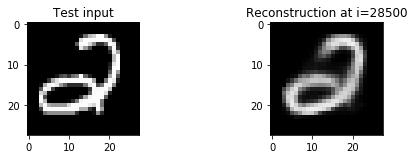

iteration: 28600, overall_loss: 26.99578857421875, recon_loss: 15.869844436645508, kl_loss: 11.125944137573242
iteration: 28700, overall_loss: 27.841312408447266, recon_loss: 17.015472412109375, kl_loss: 10.82583999633789
iteration: 28800, overall_loss: 27.660619735717773, recon_loss: 17.14763641357422, kl_loss: 10.512983322143555
iteration: 28900, overall_loss: 28.109172821044922, recon_loss: 17.670061111450195, kl_loss: 10.439111709594727
iteration: 29000, overall_loss: 28.45490074157715, recon_loss: 17.753948211669922, kl_loss: 10.700952529907227


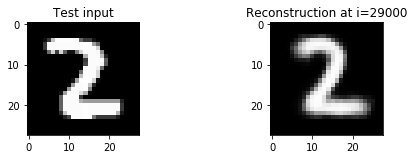

iteration: 29100, overall_loss: 27.8857421875, recon_loss: 17.074020385742188, kl_loss: 10.81171989440918
iteration: 29200, overall_loss: 26.292293548583984, recon_loss: 15.45865535736084, kl_loss: 10.833638191223145
iteration: 29300, overall_loss: 27.180320739746094, recon_loss: 16.583988189697266, kl_loss: 10.596332550048828
iteration: 29400, overall_loss: 26.963687896728516, recon_loss: 16.463340759277344, kl_loss: 10.500347137451172
iteration: 29500, overall_loss: 26.781341552734375, recon_loss: 16.080768585205078, kl_loss: 10.700572967529297


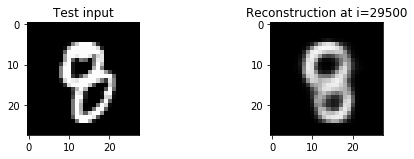

iteration: 29600, overall_loss: 25.4747257232666, recon_loss: 14.701305389404297, kl_loss: 10.773419380187988
iteration: 29700, overall_loss: 26.857376098632812, recon_loss: 15.670578002929688, kl_loss: 11.186800003051758
iteration: 29800, overall_loss: 28.38733673095703, recon_loss: 17.236835479736328, kl_loss: 11.150498390197754
iteration: 29900, overall_loss: 27.252519607543945, recon_loss: 16.00863265991211, kl_loss: 11.243888854980469


In [316]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
    
    if not i % 100:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        print("iteration: {}, overall_loss: {}, recon_loss: {}, kl_loss: {}".format(
            i, ls, np.mean(i_ls), np.mean(d_ls)))
    if not i % 500:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.figure(figsize=(8, 12))
        plt.subplot(5, 2, 2 + 1)
        plt.imshow(np.reshape(batch[0], [28, 28]), vmin=0, vmax=1, cmap="gray")
        plt.title("Test input")
        plt.subplot(5, 2, 2 + 2)
        plt.imshow(d[0], vmin=0, vmax=1, cmap="gray")
        plt.title("Reconstruction at i={}".format(i))
        plt.show()

writer.close()

# Randomly generate some images from normal distribution

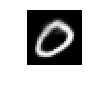

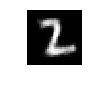

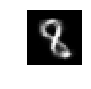

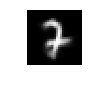

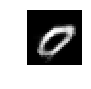

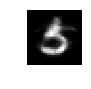

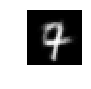

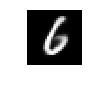

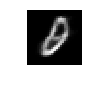

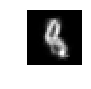

In [318]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')